In [50]:
import torch

#from ignite.metrics import MeanAbsoluteRelativeError

import torch.nn as nn
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from joblib import dump,load
import time
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.io import loadmat
import scipy.io
'''
from google.colab import drive
drive.mount('/content/drive')'''

global device, print_freq
device = torch.device('cuda')

In [51]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, inp, out):
        self.inp = inp
        self.out = out

    def __len__(self):
        return self.inp.shape[0]

    def __getitem__(self, index):
        return self.inp[index], self.out[index]

class MyDataset2(torch.utils.data.Dataset):

    def __init__(self, inp):
        self.inp = inp

    def __len__(self):
        return self.inp.shape[0]

    def __getitem__(self, index):
        return self.inp[index]


class AverageMeter(object):
    # Computes and stores the average and current value

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [52]:
def train_step(train_loader, model, criterion, optimizer, epoch, net_info):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.to(device)
        target = target.to(device)

        # compute output
        output = model(input)
        
     
        loss = criterion(output, target)

        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # compute gradient and do the SGD step
        optimizer.zero_grad()
        loss.backward(retain_graph=True)

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 25 == 0:

            if i % print_freq == 0:
                curr_lr = optimizer.param_groups[0]['lr']
                print('Epoch: [{0}/{1}][{2}/{3}]\t'
                    'LR: {4}\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.6f})\t'.format(
                    epoch, net_info['epochs'], i, len(train_loader), curr_lr,
                    batch_time=batch_time, data_time=data_time, loss=losses))

    return losses.avg


def test_step(val_loader, model, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    # violation = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):

        input = input.to(device)
        target = target.to(device)

        # compute output
        output = model(input)

        loss = criterion(output, target)

        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 25 == 0:
            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.4f})\t'.format(
                    i, len(val_loader), batch_time=batch_time, loss=losses))

    return losses.avg

In [53]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best_ANN.pth.tar')


def train_NN(model, net_info, train_loader, test_loader):
    epochs = net_info['epochs']
    train_losses = np.empty([epochs, 1])
    test_losses = np.empty([epochs, 1])

    min_loss = 1e4

    # In this case, we should use the binary cross-entropy as the loss function
    lossfun = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'],weight_decay=1e-5)

    for epoch in range(epochs):
        # adjust learning rate
        if epoch >= 50:
            if epoch % 50 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= net_info['lr_decay']

        # train for one epoch
        train_losses_temp = train_step(train_loader, model, lossfun, optimizer, epoch, net_info)
        train_losses[epoch] = train_losses_temp

        # evaluate on test set
        test_losses_temp = test_step(test_loader, model, lossfun, epoch)
        test_losses[epoch] = test_losses_temp

        # remember the best test set performance and save checkpoint
        is_best = test_losses[epoch] < min_loss
        min_loss = min(test_losses[epoch], min_loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'min_loss': min_loss,
            'optimizer': optimizer.state_dict(),
        }, is_best)

    test_losses.tofile('val_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")
    train_losses.tofile('train_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")

    # plot training/test loss
    plt.figure(figsize=(5, 3.5))
    plt.plot(train_losses, label='training')
    plt.plot(test_losses, '--', label='test')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.title('Training loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

    return model


In [54]:
trainer_info = {'epochs': 300,
                'train_size': 3100,
                'train_batch': 128,
                'test_batch': 256,
                'lr0': 3e-4,
                'lr_decay': 0.7}

note = 'ANN_Latent'

print_freq = 300

model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(trainer_info['epochs']) + 'ep_' + note
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('model name: ' + model_name)
print(device)

model name: model_3100train_300ep_ANN_Latent
cuda


In [55]:
class ANN(nn.Module):
    
  def __init__(self):
    super().__init__()

    self.fc1=torch.nn.Linear(in_features=512+4,out_features=4096,bias=True)
    self.fc2=torch.nn.Linear(in_features=4096,out_features=2048,bias=True)
    self.fc3=torch.nn.Linear(in_features=2048,out_features=1024,bias=True)
    self.fc4=torch.nn.Linear(in_features=1024,out_features=512,bias=True)
    self.fc5=torch.nn.Linear(in_features=512,out_features=256,bias=True)
    self.fc6=torch.nn.Linear(in_features=256,out_features=128,bias=True)
    self.fc7=torch.nn.Linear(in_features=128,out_features=64,bias=True)
    self.fc8=torch.nn.Linear(in_features=64,out_features=32,bias=True)
    self.fc9=torch.nn.Linear(in_features=32,out_features=3,bias=True)
    #self.actfun=torch.nn.LeakyReLU(negative_slope=0.1)
    self.actfun=torch.nn.ReLU()
    self.dropout=torch.nn.Dropout(0.3)
    self.sigmoid=torch.nn.Sigmoid()

  def forward(self,x):
    out=self.fc1(x)
    #out=self.dropout(out)
    out=self.actfun(out)

    out=self.fc2(out)
    #out=self.dropout(out)
    out=self.actfun(out)

    out=self.fc3(out)
    #out=self.dropout(out)
    out=self.actfun(out)

    out=self.fc4(out)
    out=self.actfun(out)

    out=self.fc5(out)
    out=self.actfun(out)
    
    out=self.fc6(out)
    out=self.actfun(out)
    
    out=self.fc7(out)
    out=self.actfun(out)
    
    out=self.fc8(out)
    out=self.actfun(out)
    
    out=self.fc9(out)
    out=self.sigmoid(out)

    return out


In [56]:
def main_program_encoded(inp, out, trainer_info,model_name):

    num_sample = trainer_info['train_size']
    inp_train = inp[0:num_sample]
    out_train = out[0:num_sample]
    training_set = MyDataset(inp_train, out_train)

    inp_test = inp[num_sample:num_sample+600]
    out_test = out[num_sample:num_sample+600]

    '''inp_test = inp[0:num_sample, :, :,:]
    out_test = out[0:num_sample]'''

    test_set = MyDataset(inp_test, out_test)



    # create training/test loaders
    train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)


    # train the model
    model = ANN().to(device)
    print(model_name)
    print(model)

    model = train_NN(model, trainer_info, train_loader, test_loader)
    torch.save(model.state_dict(), model_name)

    return model

In [57]:
imgs2=np.load('cnn_rve_masks_part2_rve.npy')
matsp=np.load('cnn_mat_props_part2.npy')
labels2=np.load('cnn_homogenized_stiffness_part2.npy')

print(labels2[:,0])

labl2=MinMaxScaler()
labels2=labl2.fit_transform(labels2)

matp=MinMaxScaler()
matsp=matp.fit_transform(matsp)

[63042768.77867929 51354252.25300512  7826134.83326148 ...
  7152853.23407924   352647.4342427    243162.41025909]


In [58]:
In=loadmat('Encoded_image.mat')
Y_input_feature=In['Encoded'].astype(np.float32)

Y_input_feature=torch.from_numpy(Y_input_feature).to(device)

In=loadmat('Labels.mat')
labels_tensor2=In['labels'].astype(np.float32)

labels_tensor2=torch.from_numpy(labels_tensor2).to(device)


model_3100train_300ep_ANN_Latent
ANN(
  (fc1): Linear(in_features=516, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=64, bias=True)
  (fc8): Linear(in_features=64, out_features=32, bias=True)
  (fc9): Linear(in_features=32, out_features=3, bias=True)
  (actfun): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)
Epoch: [0/300][0/25]	LR: 0.0003	Time 0.012 (0.012)	Data 0.002 (0.002)	Loss 0.2155021 (0.215502)	
Test: [0/3]	Time 0.006 (0.006)	Loss 0.0826545 (0.0827)	
Epoch: [25/300][0/25]	LR: 0.0003	Time 0.009 (0.009)	Data 0.002 (0.002)	Loss 0.0009519 (0.000952)	
Test: [0/3]	Time 0.005 (0.005)	Loss 0.0005680 (0.0006)	
Epoch: [50

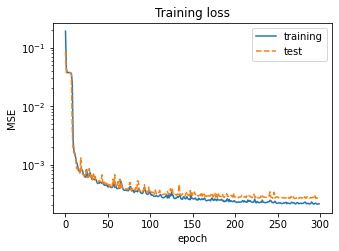

In [43]:
print_freq = 50

#device = torch.device('cuda')
model = main_program_encoded(Y_input_feature, labels_tensor2, trainer_info, model_name)

In [59]:
best_model_params = torch.load('model_best_ANN.pth.tar', map_location=device)['state_dict']

In [60]:
model = ANN().to(device)
model.load_state_dict(best_model_params)

<All keys matched successfully>

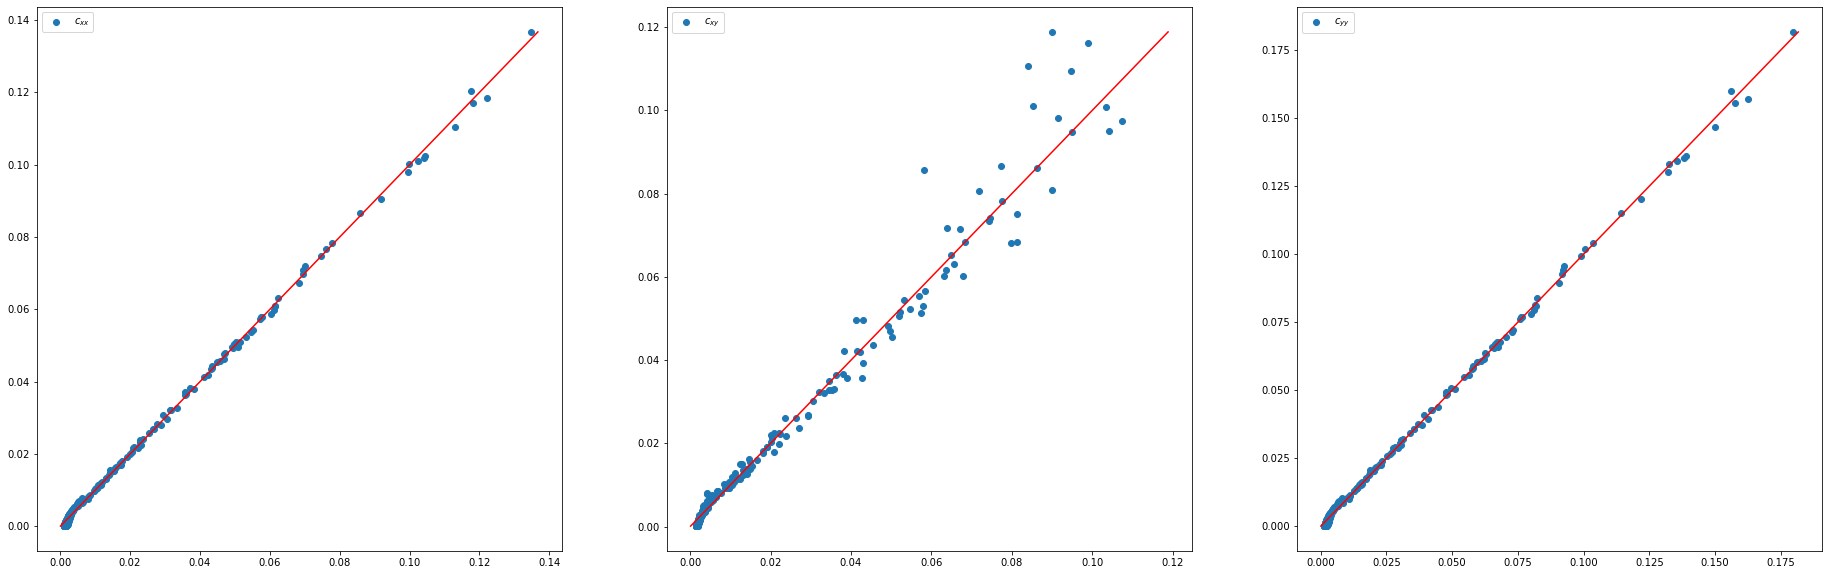

In [61]:
ypred = model(Y_input_feature[3700:4000]).to(device)

fig,ax=plt.subplots(1,3,figsize=(32,10))

ax[0].scatter(labl2.inverse_transform(ypred.cpu().detach().numpy())[:,0]/(10**9),labl2.inverse_transform(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,0]/(10**9),label='$c_{xx}$')
ax[0].plot((np.min(labl2.inverse_transform(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,0])/(10**9),np.max(labl2.inverse_transform(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,0])/(10**9)),(np.min(labl2.inverse_transform(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,0])/(10**9),np.max(labl2.inverse_transform(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,0])/(10**9)),color='red')
ax[0].legend()
ax[1].scatter(labl2.inverse_transform(ypred.cpu().detach().numpy())[:,1]/10**6,labl2.inverse_transform(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,1]/10**6,label='$c_{xy}$')
ax[1].plot((np.min(labl2.inverse_transform(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,1])/10**6,np.max(labl2.inverse_transform(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,1])/10**6),(np.min(labl2.inverse_transform(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,1])/(10**6),np.max(labl2.inverse_transform(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,1])/(10**6)),color='red')
ax[1].legend()
ax[2].scatter(labl2.inverse_transform(ypred.cpu().detach().numpy())[:,2]/(10**9),labl2.inverse_transform(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,2]/(10**9),label='$c_{yy}$')
ax[2].plot((np.min(labl2.inverse_transform(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,2])/(10**9),np.max(labl2.inverse_transform(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,2])/(10**9)),(np.min(labl2.inverse_transform(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,2])/(10**9),np.max(labl2.inverse_transform(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,2])/(10**9)),color='red')
ax[2].legend()

In [83]:
'''print(ypred.shape)
print(labels_tensor2.cpu().detach().numpy()[0:300,:].shape)'''
CNN_autoenc=r2_score((ypred.cpu().detach().numpy())[:,1],(labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,1])
print(f'R2 score for cxy is:{CNN_autoenc:0.6f}')

R2 score for cxy is:0.974696


In [81]:
mape=mean_absolute_percentage_error((ypred.cpu().detach().numpy())[:,1], (labels_tensor2.cpu().detach().numpy()[3700:4000,:])[:,1])

print(f'Mean absolute relative error for cxy is : {mape:.6f}')

Mean absolute relative error for cxy is : 0.359519
